# CatBoost Pipeline для Optiver Trading at the Close

Полноценный ML-пайплайн с CatBoost для предсказания движения цен на NASDAQ.

**Задача:** Регрессия (предсказание движения цен)  
**Метрика:** MAE (Mean Absolute Error)  
**Модель:** CatBoost с GPU ускорением

## Содержание
1. Setup и импорты
2. Загрузка данных и time-based split
3. Feature Engineering (sklearn трансформер)
4. Baseline CatBoost Pipeline
5. Optuna оптимизация гиперпараметров
6. Feature importance и финальная модель

## 1. Setup и импорты

In [21]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pickle
import time

# Sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

# CatBoost
from catboost import CatBoostRegressor, Pool

# Optuna для оптимизации гиперпараметров
import optuna
from optuna.samplers import TPESampler

# Настройки
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Пути к данным
PROJECT_ROOT = Path('/root/Optiver')
DATA_DIR = PROJECT_ROOT / 'data'
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH = DATA_DIR / 'example_test_files' / 'test.csv'
MODELS_DIR = PROJECT_ROOT / 'models'

# Создаём папку для моделей
MODELS_DIR.mkdir(exist_ok=True)

print(f'Project root: {PROJECT_ROOT}')
print(f'Train file exists: {TRAIN_PATH.exists()}')
print(f'Test file exists: {TEST_PATH.exists()}')

Project root: /root/Optiver
Train file exists: True
Test file exists: True


## 2. Загрузка данных и time-based split

In [2]:
# Оптимизированные типы данных для экономии памяти
dtypes = {
    'stock_id': 'int16',
    'date_id': 'int16',
    'seconds_in_bucket': 'int16',
    'imbalance_size': 'float32',
    'imbalance_buy_sell_flag': 'int8',
    'reference_price': 'float32',
    'matched_size': 'float32',
    'far_price': 'float32',
    'near_price': 'float32',
    'bid_price': 'float32',
    'bid_size': 'float32',
    'ask_price': 'float32',
    'ask_size': 'float32',
    'wap': 'float32',
    'target': 'float32',
    'time_id': 'int32',
    'row_id': 'str'
}

print('Загрузка данных...')
train_df = pd.read_csv(TRAIN_PATH, dtype=dtypes)
print(f'Train shape: {train_df.shape}')
print(f'Memory usage: {train_df.memory_usage(deep=True).sum() / 1e6:.2f} MB')

# Проверка пропущенных значений
missing = train_df.isnull().sum()
missing_pct = (missing / len(train_df) * 100).round(2)
print('\nПропущенные значения:')
print(pd.DataFrame({'count': missing, 'percent': missing_pct})[missing > 0])

# Удаление строк с пропущенным target
print(f'\nСтрок до удаления пропущенных target: {len(train_df):,}')
train_df = train_df.dropna(subset=['target'])
print(f'Строк после удаления: {len(train_df):,}')

Загрузка данных...
Train shape: (5237980, 17)
Memory usage: 639.15 MB

Пропущенные значения:
                   count  percent
imbalance_size       220     0.00
reference_price      220     0.00
matched_size         220     0.00
far_price        2894342    55.26
near_price       2857180    54.55
bid_price            220     0.00
ask_price            220     0.00
wap                  220     0.00
target                88     0.00

Строк до удаления пропущенных target: 5,237,980
Строк после удаления: 5,237,892


In [3]:
# Time-based split: последние 20% дат для валидации
n_dates = train_df['date_id'].nunique()
val_dates = int(n_dates * 0.2)
split_date = train_df['date_id'].max() - val_dates

print(f'Всего уникальных дат: {n_dates}')
print(f'Split date_id: {split_date}')
print(f'Train dates: 0 до {split_date}')
print(f'Validation dates: {split_date + 1} до {train_df["date_id"].max()}')

# Создание масок для train/val
train_mask = train_df['date_id'] <= split_date
val_mask = train_df['date_id'] > split_date

train_data = train_df[train_mask].copy()
val_data = train_df[val_mask].copy()

print(f'\nTrain size: {len(train_data):,} ({len(train_data)/len(train_df)*100:.1f}%)')
print(f'Validation size: {len(val_data):,} ({len(val_data)/len(train_df)*100:.1f}%)')

Всего уникальных дат: 481
Split date_id: 384
Train dates: 0 до 384
Validation dates: 385 до 480

Train size: 4,181,948 (79.8%)
Validation size: 1,055,944 (20.2%)


## 3. Feature Engineering (sklearn трансформер)

Создаём трансформер для генерации признаков на основе EDA:
- `book_imbalance`: bid_size - ask_size (топ корреляция с target)
- `wap_ref_diff`: wap - reference_price
- `spread`: ask_price - bid_price
- `imbalance_ratio`: imbalance_size / matched_size
- `mid_price`: (bid_price + ask_price) / 2
- `spread_pct`: spread / wap * 10000 (spread в basis points)
- `normalized_book_imbalance`: (bid_size - ask_size) / (bid_size + ask_size)

In [ ]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Sklearn-совместимый трансформер для генерации признаков.
    Создаёт признаки на основе EDA анализа.
    """
    
    def __init__(self):
        self.feature_names_out_ = None
    
    def fit(self, X, y=None):
        """Fit не требует обучения, просто возвращает self."""
        return self
    
    def transform(self, X):
        """Добавляет признаки к данным."""
        X = X.copy()
        
        # Book imbalance - топ корреляция с target
        X['book_imbalance'] = X['bid_size'] - X['ask_size']
        
        # WAP to reference price difference
        X['wap_ref_diff'] = X['wap'] - X['reference_price']
        
        # Bid-ask spread
        X['spread'] = X['ask_price'] - X['bid_price']
        
        # Imbalance ratio (защита от деления на ноль)
        X['imbalance_ratio'] = X['imbalance_size'] / (X['matched_size'] + 1e-8)
        
        # Mid price
        X['mid_price'] = (X['bid_price'] + X['ask_price']) / 2
        
        # Spread в basis points
        X['spread_pct'] = X['spread'] / (X['wap'] + 1e-8) * 10000
        
        # Normalized book imbalance
        X['normalized_book_imbalance'] = (X['bid_size'] - X['ask_size']) / (X['bid_size'] + X['ask_size'] + 1e-8)
        
        # Флаги наличия far_price и near_price
        X['has_far_price'] = (~X['far_price'].isna()).astype('int8')
        X['has_near_price'] = (~X['near_price'].isna()).astype('int8')
        
        # Заполнение пропусков в far_price и near_price медианой reference_price
        X['far_price'] = X['far_price'].fillna(X['reference_price'])
        X['near_price'] = X['near_price'].fillna(X['reference_price'])
        
        # Разница far/near от reference
        X['far_ref_diff'] = X['far_price'] - X['reference_price']
        X['near_ref_diff'] = X['near_price'] - X['reference_price']
        
        self.feature_names_out_ = X.columns.tolist()
        return X
    
    def get_feature_names_out(self, input_features=None):
        """Возвращает имена признаков после трансформации."""
        return self.feature_names_out_

feature_engineer = FeatureEngineer()
train_transformed = feature_engineer.fit_transform(train_data)
val_transformed = feature_engineer.transform(val_data)

print(f'Train shape после трансформации: {train_transformed.shape}')
print(f'Validation shape после трансформации: {val_transformed.shape}')
print(f'\nНовые признаки:')
new_features = [c for c in train_transformed.columns if c not in train_data.columns]
new_features

Train shape после трансформации: (4181948, 28)
Validation shape после трансформации: (1055944, 28)

Новые признаки:
['book_imbalance', 'wap_ref_diff', 'spread', 'imbalance_ratio', 'mid_price', 'spread_pct', 'normalized_book_imbalance', 'has_far_price', 'has_near_price', 'far_ref_diff', 'near_ref_diff']


## 4. Baseline CatBoost Pipeline

Создаём sklearn Pipeline с FeatureEngineer и CatBoostRegressor:
- GPU ускорение (`task_type='GPU'`)
- MAE как функция потерь (`loss_function='MAE'`)
- Early stopping для предотвращения переобучения
- Категориальные признаки: `stock_id`, `imbalance_buy_sell_flag`

In [22]:
# Определяем признаки для обучения
drop_cols = ['row_id', 'time_id', 'target', 'date_id']
cat_features = ['stock_id', 'imbalance_buy_sell_flag']

# Получаем имена признаков после трансформации
feature_cols = [c for c in train_transformed.columns if c not in drop_cols]
cat_feature_indices = [feature_cols.index(c) for c in cat_features]

print(f'Всего признаков: {len(feature_cols)}')
print(f'Категориальные признаки: {cat_features}')
print(f'Индексы категориальных признаков: {cat_feature_indices}')

Всего признаков: 24
Категориальные признаки: ['stock_id', 'imbalance_buy_sell_flag']
Индексы категориальных признаков: [0, 3]


In [6]:
# Подготовка данных для CatBoost
X_train = train_transformed[feature_cols].copy()
y_train = train_transformed['target'].values

X_val = val_transformed[feature_cols].copy()
y_val = val_transformed['target'].values

# Проверяем на NaN в фичах
print(f'NaN в X_train: {X_train.isna().sum().sum()}')
print(f'NaN в X_val: {X_val.isna().sum().sum()}')
print(f'\nX_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')

NaN в X_train: 1170
NaN в X_val: 810

X_train shape: (4181948, 24)
X_val shape: (1055944, 24)


In [ ]:
# Заполняем оставшиеся NaN
nan_cols = X_train.columns[X_train.isna().any()].tolist()
print(f'Колонки с NaN: {nan_cols}')

# Заполняем медианой по колонке
for col in nan_cols:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_val[col] = X_val[col].fillna(median_val)

print(f'\nNaN после заполнения:')
print(f'X_train: {X_train.isna().sum().sum()}')
print(f'X_val: {X_val.isna().sum().sum()}')

Колонки с NaN: ['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'ask_price', 'wap', 'wap_ref_diff', 'spread', 'imbalance_ratio', 'mid_price', 'spread_pct', 'far_ref_diff', 'near_ref_diff']

NaN после заполнения:

NaN после заполнения:
X_train: 0
X_val: 0
X_train: 0
X_val: 0


In [ ]:
# Baseline CatBoost модель с GPU
baseline_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': RANDOM_STATE,
    'verbose': 100,
    'early_stopping_rounds': 50,
}

print(f'Параметры: {baseline_params}')

# Создаём CatBoost Pool для эффективной работы с данными
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features=cat_features
)

# Обучение модели
start_time = time.time()
baseline_model = CatBoostRegressor(**baseline_params)
baseline_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True
)
training_time = time.time() - start_time

print(f'\nОбучение завершено за {training_time/60:.1f} минут')
print(f'Best iteration: {baseline_model.get_best_iteration()}')

Обучение baseline CatBoost модели...
Параметры: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'MAE', 'eval_metric': 'MAE', 'task_type': 'GPU', 'devices': '0', 'random_seed': 42, 'verbose': 100, 'early_stopping_rounds': 50}


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.4944385	test: 6.0592967	best: 6.0592967 (0)	total: 481ms	remaining: 8m
100:	learn: 6.4386731	test: 6.0155908	best: 6.0155908 (100)	total: 39.5s	remaining: 5m 51s
100:	learn: 6.4386731	test: 6.0155908	best: 6.0155908 (100)	total: 39.5s	remaining: 5m 51s
200:	learn: 6.4137962	test: 5.9973971	best: 5.9973971 (200)	total: 1m 17s	remaining: 5m 9s
200:	learn: 6.4137962	test: 5.9973971	best: 5.9973971 (200)	total: 1m 17s	remaining: 5m 9s
300:	learn: 6.4013120	test: 5.9890946	best: 5.9890946 (300)	total: 1m 56s	remaining: 4m 29s
300:	learn: 6.4013120	test: 5.9890946	best: 5.9890946 (300)	total: 1m 56s	remaining: 4m 29s
400:	learn: 6.3943674	test: 5.9849457	best: 5.9849457 (400)	total: 2m 30s	remaining: 3m 44s
400:	learn: 6.3943674	test: 5.9849457	best: 5.9849457 (400)	total: 2m 30s	remaining: 3m 44s
500:	learn: 6.3893473	test: 5.9818669	best: 5.9818669 (500)	total: 3m 6s	remaining: 3m 5s
500:	learn: 6.3893473	test: 5.9818669	best: 5.9818669 (500)	total: 3m 6s	remaining: 3m 5s
600:	

In [ ]:
# Оценка baseline модели
train_pred = baseline_model.predict(X_train)
val_pred = baseline_model.predict(X_val)

train_mae = mean_absolute_error(y_train, train_pred)
val_mae = mean_absolute_error(y_val, val_pred)

print(f'Train MAE: {train_mae:.6f}')
print(f'Validation MAE: {val_mae:.6f}')
print(f'Overfitting gap: {train_mae - val_mae:.6f}')
print(f'Best iteration: {baseline_model.get_best_iteration()}')

BASELINE CATBOOST РЕЗУЛЬТАТЫ
Train MAE: 6.372088
Validation MAE: 5.971607
Overfitting gap: 0.400481
Best iteration: 999


## 5. Optuna оптимизация гиперпараметров

Используем Optuna для поиска оптимальных гиперпараметров CatBoost:
- `depth`: глубина деревьев (4-10)
- `learning_rate`: скорость обучения (0.01-0.3)
- `iterations`: количество итераций (500-3000)
- `l2_leaf_reg`: L2 регуляризация (1-10)
- `min_data_in_leaf`: минимум данных в листе (1-100)
- `border_count`: количество бордеров для числовых признаков (32-255)

In [23]:
def objective(trial):
    """
    Optuna objective для оптимизации гиперпараметров CatBoost.
    """
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 16.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'MAE',
        'eval_metric': 'MAE',
        'task_type': 'GPU',
        'devices': '0',
        'random_seed': RANDOM_STATE,
        'verbose': 0,
        'early_stopping_rounds': 50,
    }
    
    model = CatBoostRegressor(**params)
    model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True
    )
    
    val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_pred)
    
    return val_mae

In [ ]:
# Запуск оптимизации Optuna
N_TRIALS = 20  # Количество испытаний

print(f'Запуск Optuna оптимизации с {N_TRIALS} trials...')

# Создаём study с TPE sampler
sampler = TPESampler(seed=RANDOM_STATE)
study = optuna.create_study(
    direction='minimize',  # Минимизируем MAE
    sampler=sampler,
    study_name='catboost_optiver'
)

# Оптимизация
study.optimize(
    objective,
    n_trials=N_TRIALS,
    show_progress_bar=True,
    gc_after_trial=True
)


print(f'Лучший trial: {study.best_trial.number}')
print(f'Лучший MAE: {study.best_value:.6f}')
print(f'Baseline MAE: {val_mae:.6f}')
print(f'Улучшение: {val_mae - study.best_value:.6f}')

[I 2025-12-10 22:24:32,891] A new study created in memory with name: catboost_optiver


Запуск Optuna оптимизации с 20 trials...
Это займёт некоторое время...



  0%|          | 0/20 [00:00<?, ?it/s]

Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-10 22:37:03,603] Trial 0 finished with value: 5.955035596131861 and parameters: {'iterations': 1062, 'learning_rate': 0.2536999076681772, 'depth': 9, 'l2_leaf_reg': 6.387926357773329, 'min_data_in_leaf': 16, 'border_count': 66}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-10 22:42:41,390] Trial 1 finished with value: 5.964686638275141 and parameters: {'iterations': 587, 'learning_rate': 0.19030368381735815, 'depth': 8, 'l2_leaf_reg': 7.372653200164409, 'min_data_in_leaf': 3, 'border_count': 249}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-10 22:51:57,407] Trial 2 finished with value: 5.989685843142835 and parameters: {'iterations': 1749, 'learning_rate': 0.020589728197687916, 'depth': 5, 'l2_leaf_reg': 2.650640588680904, 'min_data_in_leaf': 31, 'border_count': 149}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-10 23:02:30,998] Trial 3 finished with value: 5.983554811965372 and parameters: {'iterations': 1148, 'learning_rate': 0.02692655251486473, 'depth': 8, 'l2_leaf_reg': 2.2554447458683766, 'min_data_in_leaf': 30, 'border_count': 114}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-10 23:09:19,890] Trial 4 finished with value: 5.968374514096406 and parameters: {'iterations': 1184, 'learning_rate': 0.14447746112718687, 'depth': 5, 'l2_leaf_reg': 5.628109945722504, 'min_data_in_leaf': 60, 'border_count': 42}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-10 23:15:19,206] Trial 5 finished with value: 5.998648664366635 and parameters: {'iterations': 1411, 'learning_rate': 0.0178601378893971, 'depth': 4, 'l2_leaf_reg': 9.539969835279999, 'min_data_in_leaf': 97, 'border_count': 213}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-10 23:24:12,378] Trial 6 finished with value: 6.004745020031551 and parameters: {'iterations': 957, 'learning_rate': 0.013940346079873234, 'depth': 8, 'l2_leaf_reg': 4.961372443656412, 'min_data_in_leaf': 13, 'border_count': 142}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-10 23:27:14,590] Trial 7 finished with value: 5.973646985639589 and parameters: {'iterations': 551, 'learning_rate': 0.22038218939289875, 'depth': 5, 'l2_leaf_reg': 6.962700559185838, 'min_data_in_leaf': 32, 'border_count': 148}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-10 23:43:00,827] Trial 8 finished with value: 5.9836726669557905 and parameters: {'iterations': 1320, 'learning_rate': 0.01875220945578641, 'depth': 10, 'l2_leaf_reg': 7.976195410250031, 'min_data_in_leaf': 94, 'border_count': 232}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-10 23:47:35,604] Trial 9 finished with value: 5.967597243195095 and parameters: {'iterations': 1397, 'learning_rate': 0.22999586428143728, 'depth': 4, 'l2_leaf_reg': 2.763845761772307, 'min_data_in_leaf': 5, 'border_count': 104}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-11 00:12:20,580] Trial 10 finished with value: 5.958821775213412 and parameters: {'iterations': 1918, 'learning_rate': 0.06690992453172911, 'depth': 10, 'l2_leaf_reg': 4.414780019047117, 'min_data_in_leaf': 59, 'border_count': 40}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-11 00:38:03,291] Trial 11 finished with value: 5.9572746024176055 and parameters: {'iterations': 1967, 'learning_rate': 0.08353087730210129, 'depth': 10, 'l2_leaf_reg': 4.416438190782011, 'min_data_in_leaf': 63, 'border_count': 34}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-11 00:46:26,186] Trial 12 finished with value: 5.967102587847321 and parameters: {'iterations': 822, 'learning_rate': 0.0862550689847748, 'depth': 9, 'l2_leaf_reg': 3.945880916385662, 'min_data_in_leaf': 75, 'border_count': 72}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-11 01:03:02,000] Trial 13 finished with value: 5.969371185951018 and parameters: {'iterations': 1621, 'learning_rate': 0.037370046395123875, 'depth': 9, 'l2_leaf_reg': 6.302387280138781, 'min_data_in_leaf': 47, 'border_count': 70}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-11 01:26:31,602] Trial 14 finished with value: 5.959554051318904 and parameters: {'iterations': 1977, 'learning_rate': 0.10909414477528377, 'depth': 10, 'l2_leaf_reg': 8.467317973187747, 'min_data_in_leaf': 78, 'border_count': 32}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-11 01:32:53,499] Trial 15 finished with value: 5.980215376496627 and parameters: {'iterations': 1000, 'learning_rate': 0.04542413444873454, 'depth': 7, 'l2_leaf_reg': 3.490924636924703, 'min_data_in_leaf': 42, 'border_count': 82}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-11 01:47:58,300] Trial 16 finished with value: 5.956516990227547 and parameters: {'iterations': 1595, 'learning_rate': 0.12922648894243335, 'depth': 9, 'l2_leaf_reg': 1.084352152198723, 'min_data_in_leaf': 20, 'border_count': 177}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-11 01:59:03,204] Trial 17 finished with value: 5.956107816792067 and parameters: {'iterations': 1567, 'learning_rate': 0.2869663035482931, 'depth': 7, 'l2_leaf_reg': 1.2260353437323843, 'min_data_in_leaf': 20, 'border_count': 186}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-11 02:10:10,007] Trial 18 finished with value: 5.955970131645972 and parameters: {'iterations': 1573, 'learning_rate': 0.2734725315562641, 'depth': 7, 'l2_leaf_reg': 5.854972166592442, 'min_data_in_leaf': 15, 'border_count': 175}. Best is trial 0 with value: 5.955035596131861.


Default metric period is 5 because MAE is/are not implemented for GPU


[I 2025-12-11 02:15:21,992] Trial 19 finished with value: 5.965298875862634 and parameters: {'iterations': 774, 'learning_rate': 0.16673666314711835, 'depth': 7, 'l2_leaf_reg': 5.979628809175416, 'min_data_in_leaf': 14, 'border_count': 181}. Best is trial 0 with value: 5.955035596131861.

OPTUNA ОПТИМИЗАЦИЯ ЗАВЕРШЕНА
Лучший trial: 0
Лучший MAE: 5.955036
Baseline MAE: 5.971607
Улучшение: 0.016572


In [24]:
# Лучшие гиперпараметры
print('Лучшие гиперпараметры:')
study.best_params

Лучшие гиперпараметры:


{'iterations': 1062,
 'learning_rate': 0.2536999076681772,
 'depth': 9,
 'l2_leaf_reg': 6.387926357773329,
 'min_data_in_leaf': 16,
 'border_count': 66}

In [25]:
optuna.visualization.plot_optimization_history(study)

## 6. Feature Importance и финальная модель

Обучаем финальную модель с лучшими гиперпараметрами и анализируем важность признаков.

In [ ]:
# Обучение финальной модели с лучшими параметрами
best_params = study.best_params.copy()
best_params.update({
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': RANDOM_STATE,
    'verbose': 100,
    'early_stopping_rounds': 50,
})

print(f'Параметры: {best_params}')

# Обучение
start_time = time.time()
final_model = CatBoostRegressor(**best_params)
final_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True
)
training_time = time.time() - start_time

# Оценка
train_pred_final = final_model.predict(X_train)
val_pred_final = final_model.predict(X_val)

train_mae_final = mean_absolute_error(y_train, train_pred_final)
val_mae_final = mean_absolute_error(y_val, val_pred_final)

print(f'Train MAE: {train_mae_final:.6f}')
print(f'Validation MAE: {val_mae_final:.6f}')
print(f'Overfitting gap: {train_mae_final - val_mae_final:.6f}')
print(f'Best iteration: {final_model.get_best_iteration()}')
print(f'Обучение заняло: {training_time/60:.1f} минут')

Обучение финальной модели с лучшими гиперпараметрами...
Параметры: {'iterations': 1062, 'learning_rate': 0.2536999076681772, 'depth': 9, 'l2_leaf_reg': 6.387926357773329, 'min_data_in_leaf': 16, 'border_count': 66, 'loss_function': 'MAE', 'eval_metric': 'MAE', 'task_type': 'GPU', 'devices': '0', 'random_seed': 42, 'verbose': 100, 'early_stopping_rounds': 50}


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.4930095	test: 6.0581390	best: 6.0581390 (0)	total: 170ms	remaining: 3m
100:	learn: 6.3972608	test: 5.9851181	best: 5.9851181 (100)	total: 16.7s	remaining: 2m 39s
100:	learn: 6.3972608	test: 5.9851181	best: 5.9851181 (100)	total: 16.7s	remaining: 2m 39s
200:	learn: 6.3757321	test: 5.9721065	best: 5.9721065 (200)	total: 32.6s	remaining: 2m 19s
200:	learn: 6.3757321	test: 5.9721065	best: 5.9721065 (200)	total: 32.6s	remaining: 2m 19s
300:	learn: 6.3640480	test: 5.9659191	best: 5.9659191 (300)	total: 49.1s	remaining: 2m 4s
300:	learn: 6.3640480	test: 5.9659191	best: 5.9659191 (300)	total: 49.1s	remaining: 2m 4s
400:	learn: 6.3551268	test: 5.9623550	best: 5.9623550 (400)	total: 1m 7s	remaining: 1m 51s
400:	learn: 6.3551268	test: 5.9623550	best: 5.9623550 (400)	total: 1m 7s	remaining: 1m 51s
500:	learn: 6.3478288	test: 5.9597559	best: 5.9597559 (500)	total: 1m 26s	remaining: 1m 36s
500:	learn: 6.3478288	test: 5.9597559	best: 5.9597559 (500)	total: 1m 26s	remaining: 1m 36s
600:	le

Top-10 важных признаков:
                  feature  importance
        seconds_in_bucket   15.605434
normalized_book_imbalance   13.685128
             wap_ref_diff   12.900958
               spread_pct    6.608300
  imbalance_buy_sell_flag    6.472165
                   spread    5.939484
            near_ref_diff    5.404859
          imbalance_ratio    5.052951
                      wap    4.283081
             matched_size    3.987403


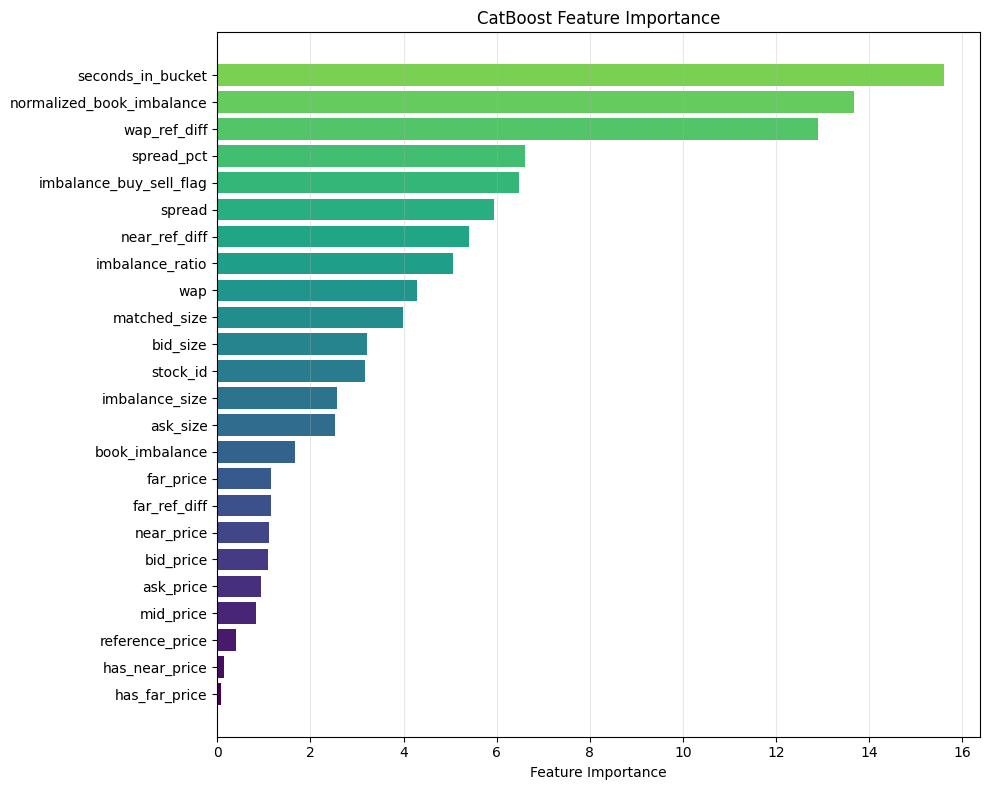


График сохранён в /root/Optiver/models/feature_importance.png


In [16]:
# Feature Importance
feature_importance = final_model.get_feature_importance()
feature_names = feature_cols

# Создаём DataFrame с важностью признаков
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print('Top-10 важных признаков:')
print(importance_df.head(10).to_string(index=False))

# Визуализация
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(importance_df)))
bars = ax.barh(importance_df['feature'], importance_df['importance'], color=colors[::-1])
ax.set_xlabel('Feature Importance')
ax.set_title('CatBoost Feature Importance')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(MODELS_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nГрафик сохранён в {MODELS_DIR / "feature_importance.png"}')

In [27]:
# Сохраняем модель в формате CatBoost
model_path = MODELS_DIR / 'catboost_final.cbm'
final_model.save_model(str(model_path))
print(f'Модель сохранена: {model_path}')

# Сохраняем также в pickle для совместимости
pickle_path = MODELS_DIR / 'catboost_final.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump({
        'model': final_model,
        'feature_cols': feature_cols,
        'cat_features': cat_features,
        'best_params': best_params,
        'feature_importance': importance_df,
        'selected_features': selected_features,
        'val_mae': val_mae_final,
    }, f)
print(f'Pickle сохранён: {pickle_path}')

# Сохраняем лучшие параметры в JSON
import json
params_path = MODELS_DIR / 'best_params.json'
params_to_save = {k: (float(v) if isinstance(v, (np.floating, float)) else 
                      int(v) if isinstance(v, (np.integer, int)) else v) 
                  for k, v in best_params.items()}
with open(params_path, 'w') as f:
    json.dump(params_to_save, f, indent=2)
print(f'Параметры сохранены: {params_path}')

Модель сохранена: /root/Optiver/models/catboost_final.cbm
Pickle сохранён: /root/Optiver/models/catboost_final.pkl
Параметры сохранены: /root/Optiver/models/best_params.json
Pickle сохранён: /root/Optiver/models/catboost_final.pkl
Параметры сохранены: /root/Optiver/models/best_params.json
